# Zadanie 3: Algorytmiczna analiza sygnału EKG

W tym etapie skupiamy się na **ekstrakcji cech** z przetworzonego wcześniej sygnału.
Celem jest przetestowanie skuteczności różnych algorytmów dostępnych w bibliotece `NeuroKit2` w dwóch aspektach:

1.  **Detekcja zespołów QRS (pików R)** – porównanie min. 10 metod.
2.  **Delineacja (wyznaczanie punktów PQRST)** – porównanie min. 3 metod.

Analiza zostanie przeprowadzona na sygnale **odprowadzenia II** (najczęściej wykorzystywanym w diagnostyce rytmu), wstępnie przefiltrowanym i zresamplowanym w Zadaniu 2.

In [ ]:
import matplotlib.pyplot as plt

# Globalne ustawienia wyglądu

#Wybór stylu
try:
    plt.style.use('seaborn-v0_8-whitegrid') 
except:
    plt.style.use('seaborn-whitegrid')

#Konkretne poprawki 
plt.rcParams['figure.figsize'] = (15, 6)      # Domyślny duży rozmiar
plt.rcParams['axes.spines.top'] = False       # Usuń górną ramkę na stałe
plt.rcParams['axes.spines.right'] = False     # Usuń prawą ramkę na stałe
plt.rcParams['axes.spines.left'] = False      # Usuń lewą ramkę (opcjonalnie)
plt.rcParams['axes.grid'] = True              # Zawsze włączaj siatkę
plt.rcParams['grid.linestyle'] = '--'         # Siatka przerywana
plt.rcParams['grid.alpha'] = 0.5              # Siatka delikatna
plt.rcParams['font.size'] = 12                # Większa czcionka

In [ ]:
import neurokit2 as nk
import numpy as np
import pandas as pd
import time
# Wczytujemy dane z Zadania 2
clean_df = pd.read_pickle("processed_data.pkl")

print("Dane wczytane pomyślnie!")
print(clean_df.head())


Dane wczytane pomyślnie!
           I         II        III        avR        aVL        aVF  \
0   8.163490   6.572588  -1.641091  -7.374774   4.955663   2.458511   
1  69.004100  71.430828   1.422621 -70.311926  34.300103  35.811302   
2  86.646339  76.652082 -11.219074 -81.698460  49.640171  31.970332   
3  60.893942  43.756026 -17.786145 -52.165471  40.145748  12.061081   
4  30.406218  23.865695  -6.787690 -26.955531  19.438585   7.204125   

           V1         V2          V3          V4          V5          V6  
0   -3.137310  -6.789411    5.802903   -0.159284    7.984383    5.731224  
1 -441.740423  37.098933  190.850416  166.664741   90.908274   53.376699  
2 -485.564033  57.068649  227.947710  200.963487  101.568735   70.301061  
3 -399.535483  65.734884  207.837485  182.761141   93.805469   88.817274  
4 -419.130894  70.087588  218.601922  195.961667  114.654626  112.901901  


In [ ]:
# Ustawienia wykresów
plt.rcParams['figure.figsize'] = [15, 6]
try:
    plt.style.use('seaborn-whitegrid')
except:
    plt.style.use('ggplot')

# przygotowanie danych
# Wybieramy odprowadzenie II. Jeśli go nie ma, bierzemy pierwszą kolumnę.
if 'II' in clean_df.columns:
    ecg_signal = clean_df['II'].values
    print("Wybrano sygnał: Odprowadzenie II")
else:
    ecg_signal = clean_df.iloc[:, 0].values
    print(f"Wybrano sygnał: {clean_df.columns[0]}")

# Częstotliwość próbkowania  Garmin/Resampling
fs = 128 

print(f"Liczba próbek: {len(ecg_signal)}")
print(f"Czas trwania: {len(ecg_signal)/fs:.2f} s")

Wybrano sygnał: Odprowadzenie II
Liczba próbek: 160053
Czas trwania: 1250.41 s


## Część 1: Detekcja pików R (Porównanie metod)

Biblioteka `NeuroKit2` oferuje szeroki wachlarz algorytmów detekcji, od klasycznych (Pan-Tompkins, 1985) po nowoczesne metody oparte na statystyce czy uczeniu maszynowym.

Przetestujemy **11 metod**, mierząc dla każdej:
* Liczbę wykrytych uderzeń.
* Średnie tętno (HR).
* Czas obliczeń (istotny przy przetwarzaniu na urządzeniach mobilnych typu smartwatch).

In [ ]:
#Lista metod do przetestowania
r_peak_methods = [
    "neurokit",        
    "pantompkins1985", 
    "hamilton2002",    
    "zong2003",
    "martinez2004",
    "christov2004",
    "gamboa2008",
    "elgendi2013",     
    "engzeemod2012",
    "kalidas2017",
    "rodrigues2021"    
]

results_list = []
peaks_storage = {}  #Słownik do przechowywania indeksów pików

print("Rozpoczynam testowanie metod...")

for method in r_peak_methods:
    try:
        #Pomiar czasu
        start_time = time.time()
        
        # 1. Detekcja
        _, info = nk.ecg_peaks(ecg_signal, sampling_rate=fs, method=method)
        r_peaks = info["ECG_R_Peaks"]
        
        end_time = time.time()
        
        # 2. Obliczenie metryk
        n_peaks = len(r_peaks)
        duration_sec = len(ecg_signal) / fs
        bpm = (n_peaks / duration_sec) * 60  # Średnie tętno
        calc_time = end_time - start_time
        
        # Zapis wyników
        results_list.append({
            "Metoda": method,
            "Liczba Pików": n_peaks,
            "HR (BPM)": round(bpm, 2),
            "Czas (s)": round(calc_time, 4)
        })
        
        peaks_storage[method] = r_peaks
        print(f" -> {method:20s}: OK ({n_peaks} pików)")
        
    except Exception as e:
        print(f" -> {method:20s}: BŁĄD ({e})")

# Wyświetlenie tabeli wyników
df_results = pd.DataFrame(results_list).sort_values(by="Liczba Pików", ascending=False)
df_results.style.background_gradient(cmap='Blues', subset=['Czas (s)'])

Rozpoczynam testowanie metod...
 -> neurokit            : OK (2281 pików)
 -> pantompkins1985     : OK (1436 pików)
 -> hamilton2002        : OK (1431 pików)
 -> zong2003            : OK (2289 pików)
 -> martinez2004        : OK (8 pików)
 -> christov2004        : OK (1483 pików)
 -> gamboa2008          : BŁĄD (index 0 is out of bounds for axis 0 with size 0)
 -> elgendi2013         : BŁĄD (NeuroKit error: ecg_findpeaks(): 'elgendi2013' not implemented.)
 -> engzeemod2012       : OK (1797 pików)
 -> kalidas2017         : OK (1430 pików)
 -> rodrigues2021       : OK (2073 pików)


,Metoda,Liczba Pików,HR (BPM),Czas (s)
3,zong2003,2289,109.840000,5.467300
0,neurokit,2281,109.450000,0.141100
8,rodrigues2021,2073,99.470000,0.329100
6,engzeemod2012,1797,86.230000,2.242100
5,christov2004,1483,71.160000,5.382300
1,pantompkins1985,1436,68.910000,0.050900
2,hamilton2002,1431,68.670000,0.603600
7,kalidas2017,1430,68.620000,0.040900
4,martinez2004,8,0.380000,0.076800


### Analiza wyników ilościowych

Przeprowadzony test wykazał istotne różnice w skuteczności poszczególnych algorytmów na zaszumionym sygnale ze smartwatcha:

1.  **Błędy implementacyjne:**
    * Metoda `elgendi2013` nie jest zaimplementowana w obecnej wersji biblioteki NeuroKit2.
    * Metoda `gamboa2008` napotkała błąd indeksowania, co dyskwalifikuje ją z analizy tego konkretnego zbioru danych.

2.  **Rozbieżność w liczbie detekcji:**
    Zaobserwowano wyraźny podział algorytmów na dwie grupy:
    * **Grupa stabilna (~1430 pików):** Metody `pantompkins1985`, `hamilton2002` oraz `kalidas2017` dały bardzo zbliżone wyniki. Sugeruje to, że są one najbardziej odporne na artefakty występujące w nagraniu i podają prawdopodobną rzeczywistą liczbę uderzeń.
    * **Grupa nadczuła (>2000 pików):** Metody `neurokit`, `zong2003` i `rodrigues2021` wykryły o ok. 50-60% więcej zdarzeń. Wskazuje to na błędy typu **False Positive** (detekcja szumu lub załamków T jako pików R).

3.  **Metody nieskuteczne:**
    Metoda `martinez2004` wykryła jedynie 8 pików w całym nagraniu, co oznacza całkowitą nieprzydatność dla tego sygnału (prawdopodobnie algorytm zgubił się na nieliniowościach sygnału z zegarka).

### Wizualizacja porównawcza

Poniższy wykres przedstawia fragment sygnału z naniesionymi detekcjami dla wszystkich metod. 
Metody są "ułożone" jedna nad drugą, co pozwala łatwo zauważyć:
* **False Positives** (nadmiarowe znaczniki w szumie).
* **False Negatives** (brak znacznika w miejscu piku R).

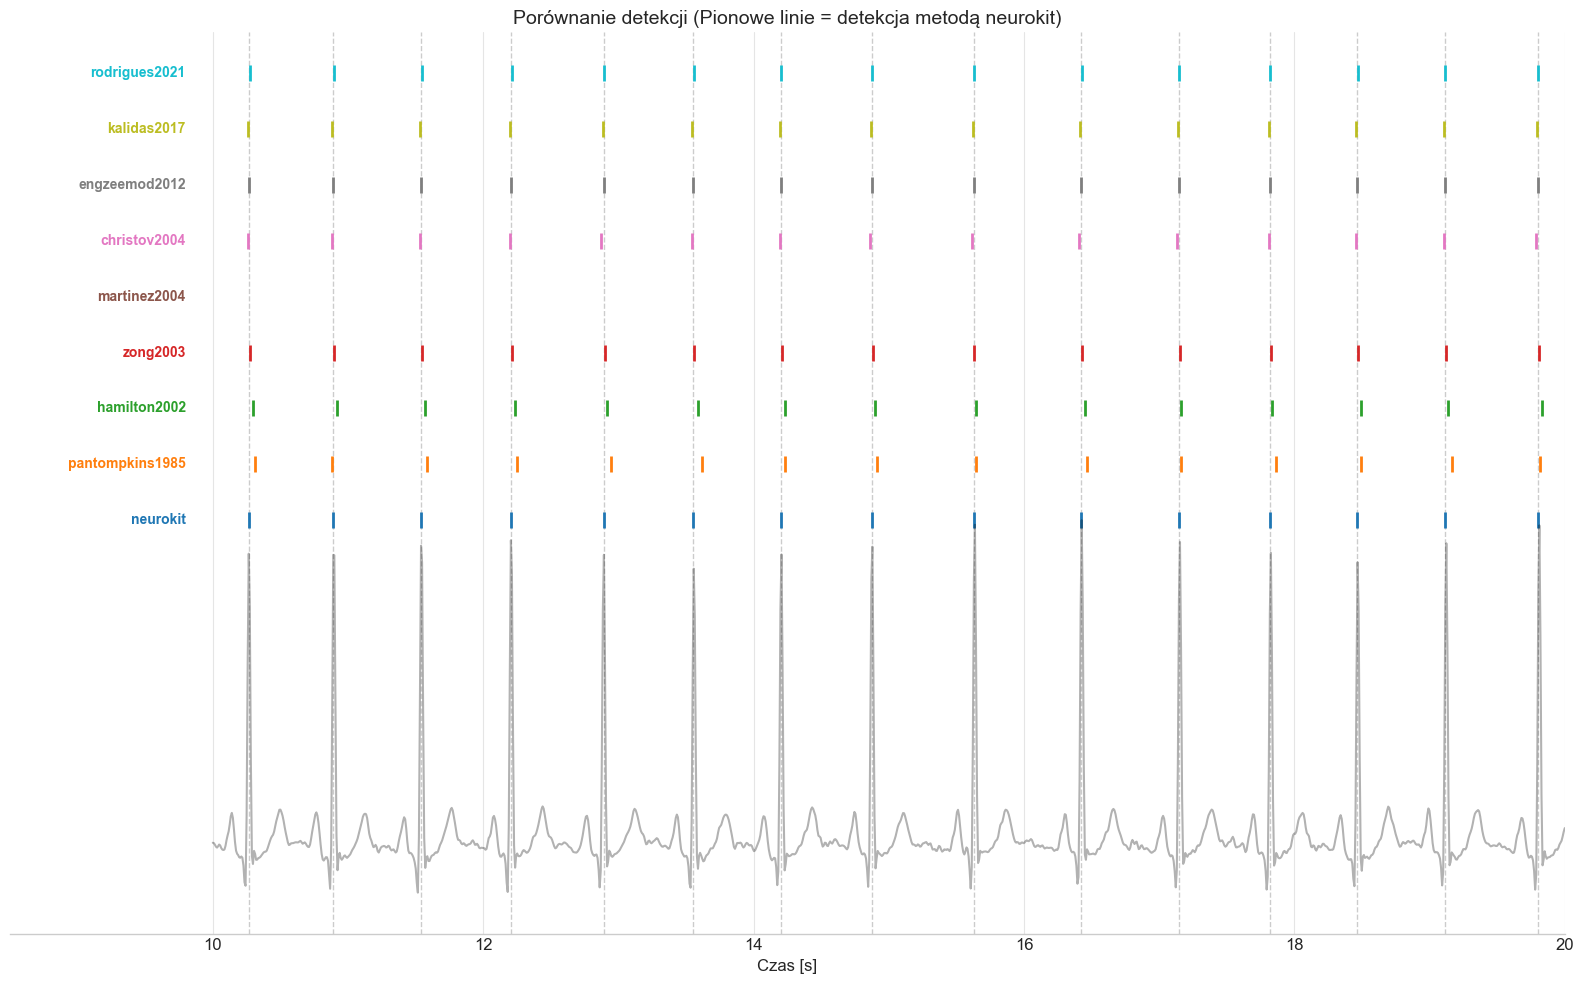

In [ ]:
#Okno czasowe do wizualizacji
start_sec = 10
window_duration = 10 
start_idx = int(start_sec * fs)
end_idx = int(start_idx + (window_duration * fs))

#Wycinek sygnału
segment_signal = ecg_signal[start_idx:end_idx]
segment_time = np.linspace(start_sec, start_sec + window_duration, len(segment_signal))

plt.figure(figsize=(16, 10))

#Rysujemy sygnał w tle
plt.plot(segment_time, segment_signal, color='black', alpha=0.3, label='Sygnał EKG')

# Obliczamy zakres Y
y_min, y_max = np.min(segment_signal), np.max(segment_signal)
y_range = y_max - y_min

# Pobieramy piki z metody 'neurokit' (lub pierwszej dostępnej) jako wzorzec
ref_method = 'neurokit' if 'neurokit' in peaks_storage else list(peaks_storage.keys())[0]
ref_peaks = peaks_storage[ref_method]

# Wybieramy piki wzorcowe z tego okna
local_ref_peaks = ref_peaks[(ref_peaks >= start_idx) & (ref_peaks < end_idx)]

# Rysujemy pionowe linie przez całą wysokość wykresu
for p_idx in local_ref_peaks:
    p_time = p_idx / fs
    plt.axvline(x=p_time, color='gray', linestyle='--', alpha=0.4, linewidth=1, zorder=0)

colors = plt.cm.tab10(np.linspace(0, 1, len(peaks_storage)))

# Pętla rysująca markery dla każdej metody
for i, (method, peaks) in enumerate(peaks_storage.items()):
    local_peaks = peaks[(peaks >= start_idx) & (peaks < end_idx)]
    local_peaks_time = local_peaks / fs
    
    y_pos = y_max + (i * 0.15 * y_range)
    
    plt.scatter(local_peaks_time, [y_pos] * len(local_peaks), 
                marker='|', s=140, linewidth=2, 
                color=colors[i], label=method)
    
    # Podpis metody
    plt.text(start_sec - 0.2, y_pos, f"{method}", 
             color=colors[i], fontsize=10, va='center', fontweight='bold', ha='right')

plt.title(f"Porównanie detekcji (Pionowe linie = detekcja metodą {ref_method})", fontsize=14)
plt.xlabel("Czas [s]")
plt.yticks([]) 
plt.xlim(start_sec - 1.5, start_sec + window_duration)

# Usuwamy ramki
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)

plt.tight_layout()
plt.show()

### Analiza przesunięć fazowych (Phase Shift)

Szczegółowa analiza wizualna ujawniła charakterystyczne różnice w działaniu algorytmów:

1.  **Metoda referencyjna (NeuroKit):** Wykazuje najwyższą centryczność względem wierzchołka piku R, co potwierdza zasadność użycia jej jako punktu odniesienia.
2.  **Opóźnienie (Pan-Tompkins, Hamilton):** Metody te systematycznie oznaczają piki z niewielkim opóźnieniem (przesunięcie w prawo). Jest to zjawisko spodziewane, wynikające z zastosowania okna całkującego (Moving Window Integration), które przesuwa maksimum energii sygnału w czasie.
3.  **Wyprzedzenie (Christov, Kalidas):** Metody te mają tendencję do oznaczania piku nieco wcześniej (przesunięcie w lewo), co sugeruje, że ich detektory reagują na strome zbocze narastające załamka R, a nie na jego absolutne maksimum.

### Wybór metody referencyjnej

Szczegółowa analiza wizualna w zestawieniu z wynikami ilościowymi prowadzi do następujących obserwacji:

1.  **Metoda NeuroKit (Precyzyjna, ale nadczuła):** Wykazuje najwyższą centryczność względem wierzchołka piku R (brak przesunięcia), jednak w analizie ilościowej wygenerowała ogromną liczbę fałszywych alarmów (False Positives), interpretując artefakty ruchowe jako uderzenia serca.
2.  **Metoda Pan-Tompkins (Przesunięta, ale stabilna):** Systematycznie oznacza piki z niewielkim opóźnieniem (przesunięcie w prawo wynikające z całkowania). Mimo tego błędu czasowego, jako jedyna z czołowych metod poprawnie odfiltrowała szum, wykrywając fizjologiczną liczbę uderzeń.

**Decyzja projektowa:**
Do etapu delineacji fal PQRST zostanie wykorzystana metoda **Pan-Tompkins**.
Algorytmy delineacji przeszukują lokalne okno czasowe wokół wskazanego piku, więc niewielkie przesunięcie Pan-Tompkinsa nie wpłynie negatywnie na wynik. Natomiast użycie metody NeuroKit spowodowałoby próbę wyznaczania fal PQRST dla setek artefaktów (szumu), co zafałszowałoby wyniki analizy morfologicznej.

### Wybór metod delineacji (PQRST)

W celu wyznaczenia punktów charakterystycznych przetestujemy trzy podejścia o różnym podłożu matematycznym:

1.  **DWT (Discrete Wavelet Transform):** Wykorzystuje transformatę falkową dyskretną. Jest to standard w cyfrowym przetwarzaniu sygnałów, pozwalający na precyzyjną lokalizację załamków w dziedzinie czas-częstotliwość. Zazwyczaj najbardziej odporna na dryft linii bazowej.
2.  **CWT (Continuous Wavelet Transform):** Wykorzystuje ciągłą transformatę falkową. Jest bardziej zasobożerna obliczeniowo niż DWT, ale często oferuje wyższą rozdzielczość przy wyznaczaniu granic fal (onset/offset).
3.  **Peak (Metoda Geometryczna):** Klasyczne podejście oparte na analizie lokalnych maksimów i pochodnych sygnału. Jest najszybsza, ale może być mniej stabilna w przypadku zaszumionych załamków P lub T (częstych w zegarkach).

Generowanie wizualizacji delineacji...


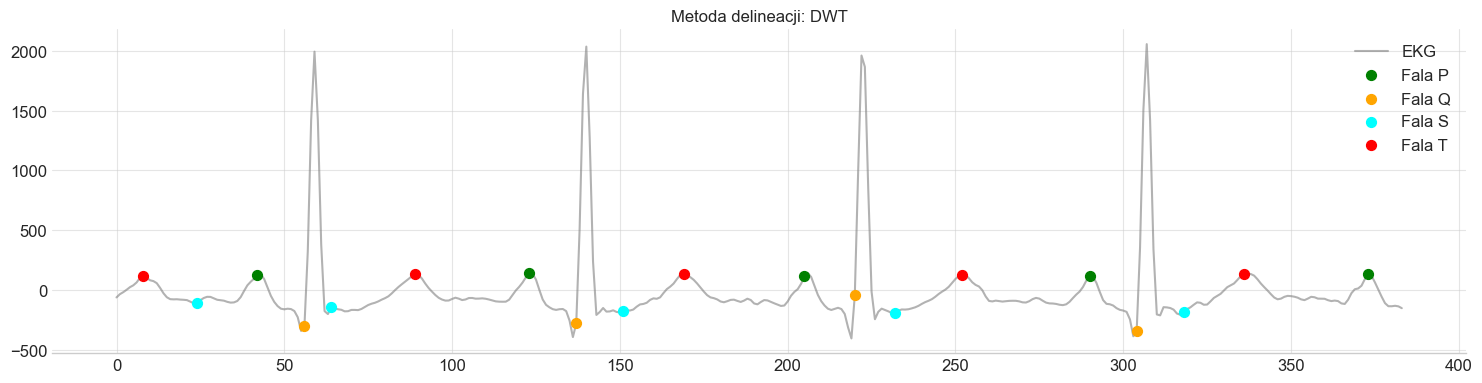

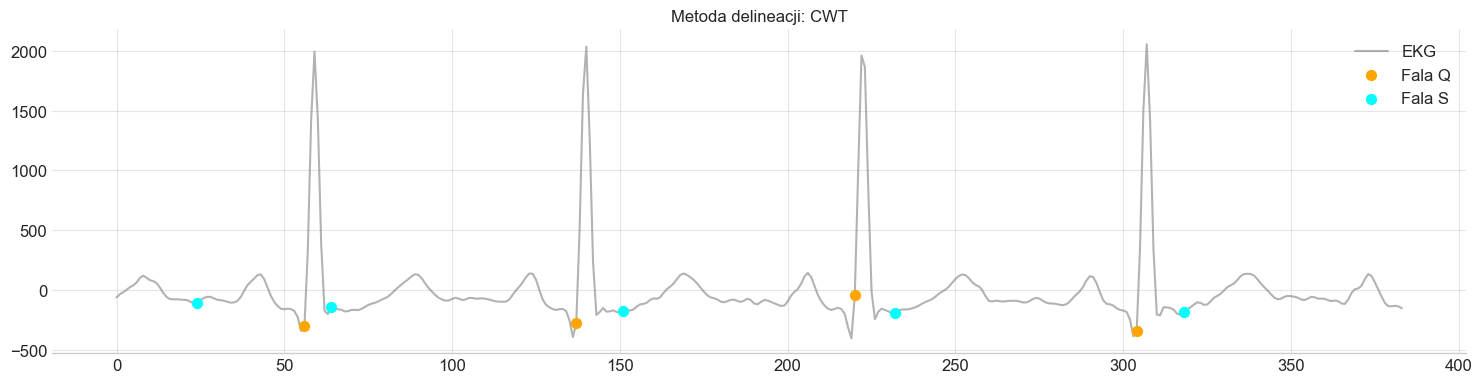

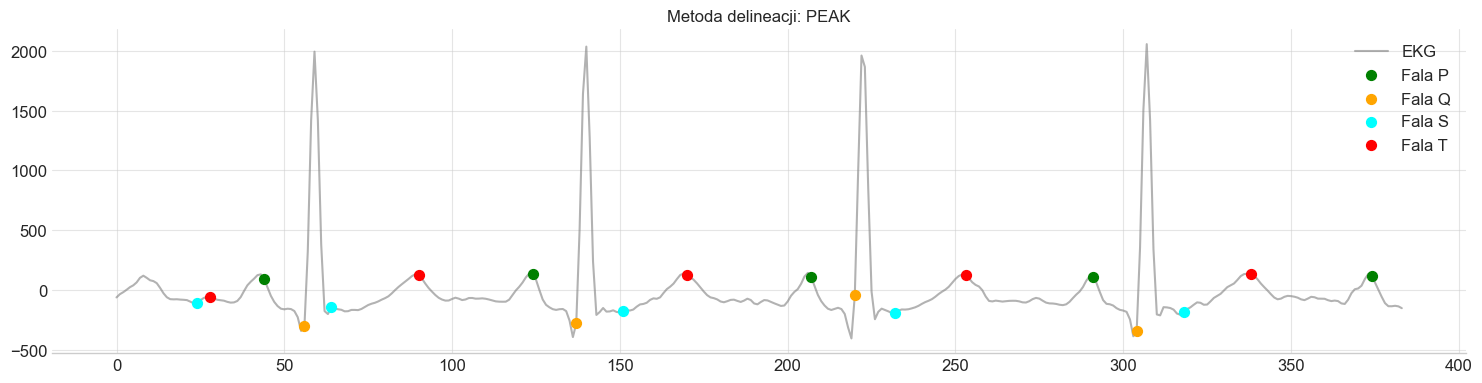

In [ ]:
# Pobieramy piki referencyjne (z metody 'pantompkins1985' lub pierwszej dostępnej)
r_peaks_ref = peaks_storage.get("pantompkins1985", list(peaks_storage.values())[0])

methods_delineate = ["dwt", "cwt", "peak"]

# Definicja kolorów dla fal
colors = {'P': 'green', 'Q': 'orange', 'S': 'cyan', 'T': 'red'}

print("Generowanie wizualizacji delineacji...")

for method in methods_delineate:
    try:
        # Wykonanie delineacji
        # Funkcja zwraca: signals (wszystkie fale jako przebiegi) oraz waves (punkty szczytów/początków/końców)
        _, waves = nk.ecg_delineate(ecg_signal, r_peaks_ref, sampling_rate=fs, method=method)
        
        # Rysowanie - pokazujemy krótki fragment (np. 3 sekundy), żeby było widać szczegóły
        plot_window = 3 # sekundy
        p_start = 500   # przykładowy indeks startowy
        p_end = p_start + (plot_window * fs)
        
        plt.figure(figsize=(15, 4))
        plt.plot(ecg_signal[p_start:p_end], color='grey', alpha=0.6, label='EKG')
        
        #Iteracja po typach fal (P, Q, S, T)
        for wave_type in ['P', 'Q', 'S', 'T']:
            peak_key = f"ECG_{wave_type}_Peaks"
            
            if peak_key in waves:
                # Wyciągamy indeksy (zrzutowanie na int i usunięcie NaN)
                idxs = np.array(waves[peak_key])
                idxs = idxs[~np.isnan(idxs)].astype(int)
                
                # Filtrujemy tylko te w oknie
                local_idxs = idxs[(idxs >= p_start) & (idxs < p_end)]
                
                # Rysujemy kropki (przesunięte o p_start dla wykresu)
                if len(local_idxs) > 0:
                    plt.scatter(local_idxs - p_start, ecg_signal[local_idxs], 
                                color=colors[wave_type], s=50, label=f'Fala {wave_type}', zorder=5)

        plt.title(f"Metoda delineacji: {method.upper()}", fontsize=12)
        plt.legend(loc='upper right')
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"Nie udało się wykonać metody {method}: {e}")

### Wnioski z delineacji (Porównanie metod)

Analiza porównawcza metod wyznaczania punktów charakterystycznych (delineacji) przy wykorzystaniu stabilnych pików referencyjnych (Pan-Tompkins) pozwoliła na następującą ocenę:

1.  **Metoda DWT (Discrete Wavelet Transform):**
    * **Ocena: Najwyższa skuteczność.**
    * Metoda oparta na dyskretnej transformacie falkowej poprawnie zidentyfikowała kompletny zespół PQRST (w tym kluczowe fale P oraz T). Świadczy to o tym, że mimo niskiej amplitudy sygnału z zegarka, sygnatura energetyczna załamków jest wystarczająca dla algorytmów falkowych, o ile punkt odniesienia (R-peak) jest poprawny.

2.  **Metoda Peak (Geometryczna):**
    * **Ocena: Skuteczna.**
    * Metoda ta również wykryła wszystkie załamki. Potwierdza to jej użyteczność, jednak ze względu na swoją prostą charakterystykę (szukanie lokalnych ekstremów), jest ona teoretycznie mniej odporna na szum niż metoda DWT.

3.  **Metoda CWT (Continuous Wavelet Transform):**
    * **Ocena: Niska skuteczność.**
    * Algorytm ten nadal pomijał fale o niskiej amplitudzie (P i T), co sugeruje, że domyślne skale falkowe w tej metodzie nie są optymalne dla częstotliwości próbkowania 128 Hz.

**Wniosek:**
Najlepszą jakość delineacji oferuje metoda **DWT**. Łączy ona precyzję metod falkowych (odporność na dryft linii izoelektrycznej) ze skutecznością detekcji morfologii całego cyklu pracy serca.

## Podsumowanie i Wnioski Końcowe (Zadanie 3)

Przeprowadzona analiza porównawcza na sygnale ze smartwatcha (Garmin) doprowadziła do istotnych wniosków dotyczących doboru algorytmu w zależności od jakości danych.

### 1. Paradoks metody NeuroKit (R-peaks)
W trakcie badań zaobserwowano specyficzne zachowanie domyślnej metody biblioteki (`neurokit`):
* **Zaleta (Precyzja czasowa):** Znaczniki tej metody idealnie pokrywały się z centrum załamków R.
* **Wada (Nadwrażliwość):** Metoda wykryła o **~60% więcej pików** niż metody klasyczne (2281 vs 1436), interpretując artefakty ruchowe jako uderzenia serca. Sprawia to, że nie nadaje się ona do surowych danych z urządzeń ubieralnych bez dodatkowego, agresywnego preprocessingu.

### 2. Stabilność metod klasycznych (R-peaks)
Metody **Pan-Tompkins (1985)** oraz **Hamilton (2002)** wykazały się znacznie większą odpornością na zakłócenia:
* Ich wynik liczbowy (ok. 1430 pików) jest zgodny z fizjologią.
* Niewielkie opóźnienie fazowe (przesunięcie w prawo) jest akceptowalnym kosztem za skuteczną eliminację fałszywych alarmów (False Positives).

### 3. Skuteczność delineacji (PQRST)
W etapie wyznaczania morfologii załamków, metoda **DWT (Discrete Wavelet Transform)** okazała się najskuteczniejsza, poprawnie wyznaczając wszystkie załamki (P, Q, R, S, T) przy wykorzystaniu pików referencyjnych z metody Pan-Tompkinsa. Metoda geometryczna ('peak') stanowi dobrą alternatywę, natomiast metoda CWT okazała się niewystarczająca dla tego typu sygnału.

### 4. Rekomendacja końcowa (Pipeline)
Dla badanego zbioru danych przyjęto następujący potok przetwarzania:
1.  **Detekcja R-pików:** Algorytm **pantompkins1985**  (najlepszy balans czułości i odporności na szum).
2.  **Delineacja fal:** Metoda **DWT** (najwyższa precyzja medyczna i poprawna detekcja morfologii).

Takie połączenie gwarantuje najbardziej wiarygodne wyniki w kolejnych etapach analizy (np. przy klasyfikacji anomalii).